## Loading data and EDA

In [1]:
import gc
gc.collect()

from utils.mnist_reader import load_mnist

import numpy as np
import pandas as pd
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_rows', 500)

import matplotlib.pyplot as plt
import seaborn as sns

import umap

from sklearn.manifold import TSNE

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold

from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import shap

In [2]:
RANDOM_STATE = 10

# Set this as per your processor cores
N_JOBS = 4

#### Loading training and testing data

In [3]:
X_train, y_train = load_mnist('data/fashion', kind='train')
X_test, y_test = load_mnist('data/fashion', kind='t10k')

In [4]:
labels = { 0: 'T-shirt/top',
          1: 'Trouser',
          2: 'Pullover',
          3: 'Dress',
          4: 'Coat', 
          5: 'Sandal',
          6: 'Shirt',
          7: 'Sneaker',
          8 : 'Bag',
          9 : 'Ankle boot'}

#### Exploring data

In [5]:
print("X_train shape : ", X_train.shape)
print("y_train shape : ", y_train.shape)

print("X_test shape : ", X_test.shape)
print("y_test shape : ", y_test.shape)

X_train shape :  (60000, 784)
y_train shape :  (60000,)
X_test shape :  (10000, 784)
y_test shape :  (10000,)


In [6]:
df_X_train =  pd.DataFrame(X_train)
df_y_train = pd.DataFrame(y_train)

df_X_test =  pd.DataFrame(X_test)
df_y_test = pd.DataFrame(y_test)

df_X_train = df_X_train.add_prefix("pixel_")
df_X_train.head(20)

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_774,pixel_775,pixel_776,pixel_777,pixel_778,pixel_779,pixel_780,pixel_781,pixel_782,pixel_783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,0,0,...,119,114,130,76,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,22,...,0,0,1,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,33,96,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,1,0,0,0,0,22,...,0,0,0,0,133,167,73,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,1,1,0,0,0,...,0,0,3,0,82,237,231,70,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


- Looking at the dimention of the data, seems like the images are flattened.
- Each image is represented as a row with 784 columns (28 * 28 = 784), each column containing a pixel density.

- Let's try to rehsape and visualize few images along with the label.

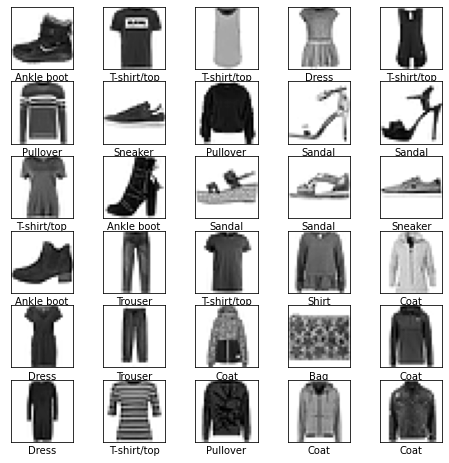

In [7]:
plt.figure(figsize=(8, 8))
# Show only the first 30 pictures
for i in range(30):
    plt.subplot(6, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[i].reshape(28,28), cmap=plt.cm.binary)
    plt.xlabel(labels[y_train[i]])

### UMAP for dimentionality reduction for data visualization

#### Need to install library --> pip install umap-learn

Uniform Manifold Approximation and Projection (UMAP) is a dimension reduction technique that can be used for visualisation similarly to t-SNE, but also for general non-linear dimension reduction.

In [8]:
umap_reduce = umap.UMAP(random_state = RANDOM_STATE, n_jobs = N_JOBS)

## Takes 3-4 minutes to fit
df_X_train_embedding = umap_reduce.fit_transform(df_X_train)

n_jobs value 4 overridden to 1 by setting random_state. Use no seed for parallelism.


In [9]:
df_X_train_embedding = pd.DataFrame(df_X_train_embedding)

df_X_train_embedding['class'] = y_train

df_X_train_embedding['class'].replace(labels, inplace=True)

df_X_train_embedding.head()

,0,1,class
0,-1.024336,3.194973,Ankle boot
1,15.132542,4.518760,T-shirt/top
2,10.555073,4.375053,T-shirt/top
3,11.564685,4.713022,Dress
4,11.550337,6.321731,T-shirt/top


#### Above table shows data reduced to 2-dim

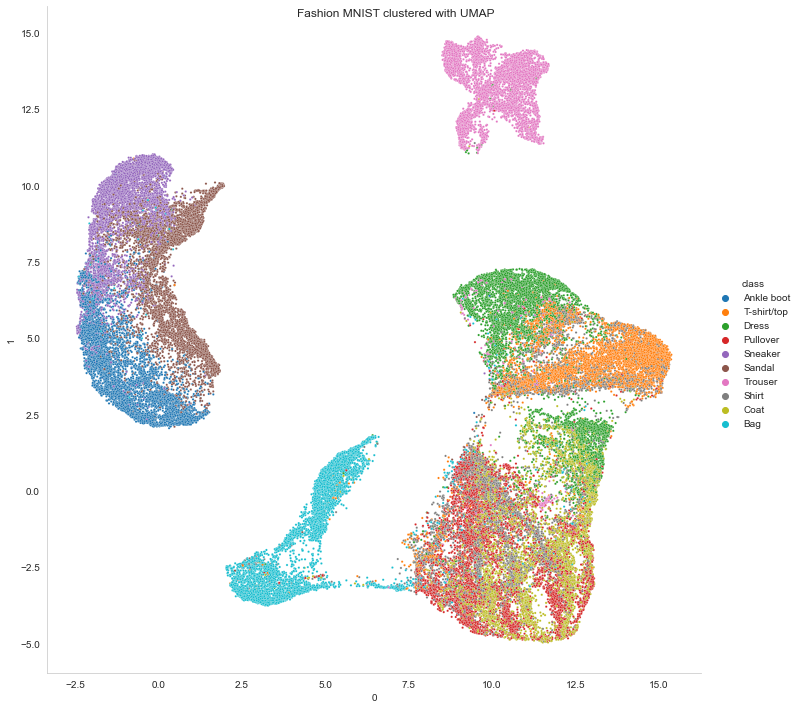

In [10]:
sns.set_style("whitegrid", {'axes.grid' : False})

#adjusting plot dots with plot_kws
ax = sns.pairplot(x_vars = [0], #column 0
                  y_vars = [1], #column 1
                  data = df_X_train_embedding, 
                  hue = "class",
                  height=10,
                  plot_kws={"s": 5});

ax.fig.suptitle('Fashion MNIST clustered with UMAP') ;

### TSNE for dimentionality reduction for data visualization

t-SNE (t-distributed Stochastic Neighbor Embedding) is an unsupervised non-linear dimensionality reduction technique for data exploration and visualizing high-dimensional data.

In [11]:
tsne_reduce = TSNE(random_state = RANDOM_STATE, n_jobs = N_JOBS)

## Takes 3-4 minutes to fit
df_X_train_tsne = tsne_reduce.fit_transform(X_train)

In [12]:
df_X_train_tsne = pd.DataFrame(df_X_train_tsne)

df_X_train_tsne['class'] = y_train

df_X_train_tsne['class'].replace(labels, inplace=True)

df_X_train_tsne.head()

,0,1,class
0,-42.905094,73.960838,Ankle boot
1,65.220520,-73.668999,T-shirt/top
2,-1.110030,-26.316572,T-shirt/top
3,10.240090,-31.399559,Dress
4,5.050550,-65.659294,T-shirt/top


#### Above table shows data reduced to 2-dim

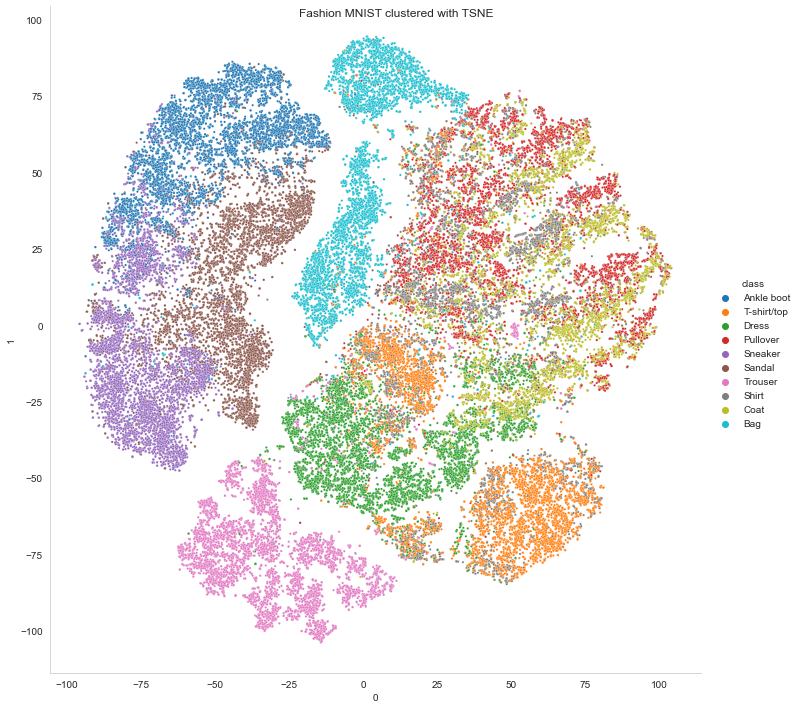

In [13]:
sns.set_style("whitegrid", {'axes.grid' : False})

#adjusting plot dots with plot_kws
ax = sns.pairplot(x_vars = [0], #column 0
                  y_vars = [1], #column 1
                  data = df_X_train_tsne, 
                  hue = "class",
                  height=10,
                  plot_kws={"s": 5});

ax.fig.suptitle('Fashion MNIST clustered with TSNE') ;

#### By above plot we can observe similarity between T-shirt/top, Pullover, Shirt, and Coat, when represented in 2-dim.

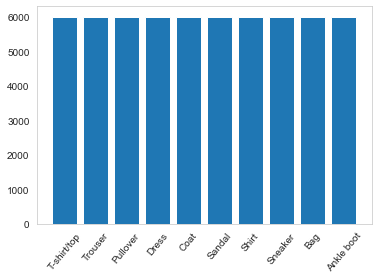

In [14]:
plt.bar(
    list(labels.values()),
    list(df_y_train.value_counts().values),
#     width = .5
    )
plt.xticks(rotation = 50)
plt.show()

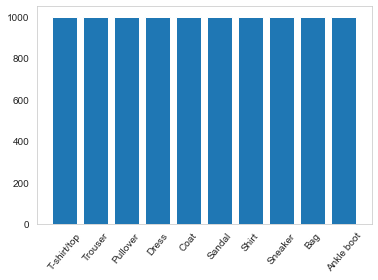

In [15]:
plt.bar(
    list(labels.values()),
    list(df_y_test.value_counts().values),
#     width = .5
    )
plt.xticks(rotation = 50)
plt.show()

#### Above bar charts shows that we have a completely balanced test and train dataset.

### Data prepration for modelling

- We will use complete training data for model training.
- We will split the test data in half to create validation set and test set.

In [16]:
X_val, X_test_fin, y_val, y_test_fin = train_test_split(X_test,
                                                    y_test,
                                                    stratify = y_test, # To get balanced data by classes in two datasets.
                                                    test_size = 0.5,
                                                    random_state = RANDOM_STATE)

In [17]:
print("X_val shape : ", X_val.shape)
print("y_val shape : ", y_val.shape)

print("X_test_fin shape : ", X_test_fin.shape)
print("y_test_fin shape : ", y_test_fin.shape)

X_val shape :  (5000, 784)
y_val shape :  (5000,)
X_test_fin shape :  (5000, 784)
y_test_fin shape :  (5000,)


In [18]:
pd.DataFrame(y_test_fin).value_counts()

0    500
1    500
2    500
3    500
4    500
5    500
6    500
7    500
8    500
9    500
dtype: int64

We can see above that the different classes have balanced data after splitting

## Experiments with models

### Baseline models

#### XGBoost baseline model

In [19]:
xgb_base = XGBClassifier(random_state = RANDOM_STATE,
                         n_jobs = N_JOBS,
                         early_stopping_rounds = 10,
                         verbosity = 1)

In [42]:
print(X_train.shape)

(60000, 784)


In [20]:
## Takes 2-3 minutes
xgb_base.fit(X_train, y_train, eval_set = [(X_val, y_val)])

[0]	validation_0-mlogloss:1.41806
[1]	validation_0-mlogloss:1.12946
[2]	validation_0-mlogloss:0.94295
[3]	validation_0-mlogloss:0.80964
[4]	validation_0-mlogloss:0.71391
[5]	validation_0-mlogloss:0.64165
[6]	validation_0-mlogloss:0.58757
[7]	validation_0-mlogloss:0.54424
[8]	validation_0-mlogloss:0.50931
[9]	validation_0-mlogloss:0.48053
[10]	validation_0-mlogloss:0.45609
[11]	validation_0-mlogloss:0.43779
[12]	validation_0-mlogloss:0.42168
[13]	validation_0-mlogloss:0.40924
[14]	validation_0-mlogloss:0.39821
[15]	validation_0-mlogloss:0.38917
[16]	validation_0-mlogloss:0.38099
[17]	validation_0-mlogloss:0.37303
[18]	validation_0-mlogloss:0.36686
[19]	validation_0-mlogloss:0.36097
[20]	validation_0-mlogloss:0.35679
[21]	validation_0-mlogloss:0.35215
[22]	validation_0-mlogloss:0.34844
[23]	validation_0-mlogloss:0.34492
[24]	validation_0-mlogloss:0.34100
[25]	validation_0-mlogloss:0.33766
[26]	validation_0-mlogloss:0.33559
[27]	validation_0-mlogloss:0.33296
[28]	validation_0-mlogloss:0.3

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [21]:
print("Minimum Validation loss : ", xgb_base.best_score)
print("Best optimization iteration : ", xgb_base.best_iteration)

Minimum Validation loss :  0.2881999630327053
Best optimization iteration :  97


In [22]:
y_pred_train_xgb_base = xgb_base.predict(X_train)

print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_xgb_base))
print("\n")

print("Confustion Matrix on train set : \n", confusion_matrix(y_train, y_pred_train_xgb_base))
print("\n")

print("Classification Report on train set : \n", classification_report(y_train, y_pred_train_xgb_base))

Accuracy on train set :  0.99965


Confustion Matrix on train set : 
 [[5997    0    0    1    0    0    2    0    0    0]
 [   0 6000    0    0    0    0    0    0    0    0]
 [   1    0 5994    0    4    0    1    0    0    0]
 [   0    0    0 5999    1    0    0    0    0    0]
 [   0    0    0    0 5999    0    1    0    0    0]
 [   0    0    0    0    0 6000    0    0    0    0]
 [   3    0    3    1    3    0 5990    0    0    0]
 [   0    0    0    0    0    0    0 6000    0    0]
 [   0    0    0    0    0    0    0    0 6000    0]
 [   0    0    0    0    0    0    0    0    0 6000]]


Classification Report on train set : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6000
           1       1.00      1.00      1.00      6000
           2       1.00      1.00      1.00      6000
           3       1.00      1.00      1.00      6000
           4       1.00      1.00      1.00      6000
           5       1.00      1.00

In [23]:
y_pred_test_xgb_base = xgb_base.predict(X_test_fin)

print("Accuracy on test set : ", accuracy_score(y_test_fin, y_pred_test_xgb_base))
print("\n")

print("Confustion Matrix on test set : \n", confusion_matrix(y_test_fin, y_pred_test_xgb_base))
print("\n")

print("Classification Report on test set : \n", classification_report(y_test_fin, y_pred_test_xgb_base))

Accuracy on test set :  0.8966


Confustion Matrix on test set : 
 [[441   0   5  11   0   0  40   0   3   0]
 [  1 488   0   8   1   0   1   0   1   0]
 [  6   1 413   3  42   0  34   0   1   0]
 [ 10   1   4 455  11   0  18   0   1   0]
 [  1   0  44  12 413   0  30   0   0   0]
 [  0   0   0   0   0 489   1   6   0   4]
 [ 62   1  51  10  44   0 326   0   6   0]
 [  0   0   0   0   0   2   0 485   0  13]
 [  0   1   1   1   3   0   4   2 488   0]
 [  0   0   0   0   0   2   0  13   0 485]]


Classification Report on test set : 
               precision    recall  f1-score   support

           0       0.85      0.88      0.86       500
           1       0.99      0.98      0.98       500
           2       0.80      0.83      0.81       500
           3       0.91      0.91      0.91       500
           4       0.80      0.83      0.81       500
           5       0.99      0.98      0.98       500
           6       0.72      0.65      0.68       500
           7       0.96      

In [24]:
print(labels)

{0: 'T-shirt/top', 1: 'Trouser', 2: 'Pullover', 3: 'Dress', 4: 'Coat', 5: 'Sandal', 6: 'Shirt', 7: 'Sneaker', 8: 'Bag', 9: 'Ankle boot'}


<H3> Observations from baseline XGBoost model.</H3>

Accuracy and F1-scores vary quite a bit between train and test set predictions, indicating overfiiting.

By looking at the confusion matrix, we can observe the classes with most mis-classified rows in test set are:
- 6 = Shirt
- 2 = Pullover
- 4 = Coat
- 0 = T-shirt/top
- 3 = Dress

Durinig the EDA by visualizing data after dimentionality reduction using TSNE, we observed similarity between T-shirt/top, Pulloveer, Shirt, and Coat, when represented in 2-dim.

#### RandomForest baseline model

In [25]:
rf_base = RandomForestClassifier(random_state = RANDOM_STATE,
                                 n_jobs = N_JOBS,
                                 verbose = 1)

In [26]:
# Takes around 1 minutes
rf_base.fit(X_train, y_train)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:   18.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:   41.2s finished


RandomForestClassifier(n_jobs=4, random_state=10, verbose=1)

In [27]:
y_pred_train_rf_base = rf_base.predict(X_train)

print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_rf_base))
print("\n")

print("Confustion Matrix on train set : \n", confusion_matrix(y_train, y_pred_train_rf_base))
print("\n")

print("Classification Report on train set : \n", classification_report(y_train, y_pred_train_rf_base))

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.4s


Accuracy on train set :  1.0


Confustion Matrix on train set : 
 [[6000    0    0    0    0    0    0    0    0    0]
 [   0 6000    0    0    0    0    0    0    0    0]
 [   0    0 6000    0    0    0    0    0    0    0]
 [   0    0    0 6000    0    0    0    0    0    0]
 [   0    0    0    0 6000    0    0    0    0    0]
 [   0    0    0    0    0 6000    0    0    0    0]
 [   0    0    0    0    0    0 6000    0    0    0]
 [   0    0    0    0    0    0    0 6000    0    0]
 [   0    0    0    0    0    0    0    0 6000    0]
 [   0    0    0    0    0    0    0    0    0 6000]]


Classification Report on train set : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      6000
           1       1.00      1.00      1.00      6000
           2       1.00      1.00      1.00      6000
           3       1.00      1.00      1.00      6000
           4       1.00      1.00      1.00      6000
           5       1.00      1.00    

[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    1.0s finished


### y_pred_test_rf_base = rf_base.predict(X_test_fin)

print("Accuracy on test set : ", accuracy_score(y_test_fin, y_pred_test_rf_base))
print("\n")

print("Confustion Matrix on test set : \n", confusion_matrix(y_test_fin, y_pred_test_rf_base))
print("\n")

print("Classification Report on test set : \n", classification_report(y_test_fin, y_pred_test_rf_base))

<H3> Observations from baseline RandomForest model.</H3>

Observations are similar between the results of XGBoost and RandomForest

Accuracy and F1-scores vary quite a bit between train and test set predictions, indicating overfiiting.

By looking at the confusion matrix, we can observe the classes with most mis-classified rows in test set are:
- 6 = Shirt
- 2 = Pullover
- 4 = Coat
- 0 = T-shirt/top
- 3 = Dress

Durinig the EDA by visualizing data after dimentionality reduction using TSNE, we observed similarity between T-shirt/top, Pulloveer, Shirt, and Coat, when represented in 2-dim.

## Model tuning and optimization

We will only optimize XGBoost and not Random Forest, as XGBoost showed better performance in baseline model.

#### Enable below code to run grid search

In [28]:
# xgb_grid_parameters = {"max_depth" : [5],
#                        "n_estimators" : [100],
# #                        "early_stopping_rounds" : [10],
#                        "reg_lambda" : [0.001, 0.01, 0.1, 1, 10], # L2/ Ridge regularization
#                        "colsample_bytree" : [0.8, 0.9]
#                       }

# kFold = StratifiedKFold(n_splits = 6)

In [29]:
# xgb_model_gs01 = GridSearchCV(estimator = XGBClassifier(random_state = RANDOM_STATE,
#                                                         verbose = 1,
#                                                         early_stopping_rounds = 10,
# #                                                         tree_method = "gpu_hist",
# #                                                         predictor = "gpu_predictor",
# #                                                         device = "cuda",
# #                                                         gpu_id = 0
#                                                        ),
#                               param_grid = xgb_grid_parameters,
#                               cv = kFold,
#                               scoring = "f1_weighted",
#                               n_jobs = N_JOBS,
#                               verbose = 1
#                               )

In [30]:
# ## Takes around 1 hr
# xgb_model_gs01.fit(X_train, y_train, eval_set = [(X_val, y_val)])

In [31]:
# print("Best Parameters as per grid search : ", xgb_model_gs01.best_params_)

In [32]:
# y_pred_train_xgb_gs01 = xgb_model_gs01.predict(X_train)

# print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_xgb_gs01))
# print("\n")

# print("Confustion Matrix on train set : \n", confusion_matrix(y_train, y_pred_train_xgb_gs01))
# print("\n")

# print("Classification Report on train set : \n", classification_report(y_train, y_pred_train_xgb_gs01))

In [33]:
# y_pred_test_xgb_gs01 = xgb_model_gs01.predict(X_test_fin)

# print("Accuracy on test set : ", accuracy_score(y_test_fin, y_pred_test_xgb_gs01))
# print("\n")

# print("Confustion Matrix on test set : \n", confusion_matrix(y_test_fin, y_pred_test_xgb_gs01))
# print("\n")

# print("Classification Report on test set : \n", classification_report(y_test_fin, y_pred_test_xgb_gs01))

<H3> Above results are similar even with parameter selection using grid search. </H3>

### Training model with best parameters from grid search

To do : Plot learning curves to chose regularization parameter.

In [34]:
xgb_model_fin = XGBClassifier(random_state = RANDOM_STATE,
                              n_jobs = N_JOBS,
                              verbose = 1,
                              early_stopping_rounds = 10,
                              colsample_bytree = 0.9,
                              max_depth = 5,
                              n_estimators = 100,
                              reg_lambda = 10,
#                               tree_method = "gpu_hist",
#                               predictor = "gpu_predictor",
#                               device = "cuda",
#                               gpu_id = 0
                              )

In [35]:
xgb_model_fin.fit(X_train,
                  y_train,
                  eval_set = [(X_val, y_val)],
                  verbose = 1
                 )

[14:33:10] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/learner.cc:767: 
Parameters: { "verbose" } are not used.

[0]	validation_0-mlogloss:1.48286
[1]	validation_0-mlogloss:1.19053
[2]	validation_0-mlogloss:1.00157
[3]	validation_0-mlogloss:0.86954
[4]	validation_0-mlogloss:0.77089
[5]	validation_0-mlogloss:0.69526
[6]	validation_0-mlogloss:0.63799
[7]	validation_0-mlogloss:0.59248
[8]	validation_0-mlogloss:0.55595
[9]	validation_0-mlogloss:0.52488
[10]	validation_0-mlogloss:0.49892
[11]	validation_0-mlogloss:0.47811
[12]	validation_0-mlogloss:0.45940
[13]	validation_0-mlogloss:0.44501
[14]	validation_0-mlogloss:0.43226
[15]	validation_0-mlogloss:0.42185
[16]	validation_0-mlogloss:0.41150
[17]	validation_0-mlogloss:0.40379
[18]	validation_0-mlogloss:0.39681
[19]	validation_0-mlogloss:0.39057
[20]	validation_0-mlogloss:0.38478
[21]	validation_0-mlogloss:0.37881
[22]	validation_0-mlogloss:0.37464
[23]	validation_0-mloglo

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.9, early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=5, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=4, num_parallel_tree=None,
              objective='multi:softprob', predictor=None, ...)

In [36]:
y_pred_train_xgb_fin = xgb_model_fin.predict(X_train)

print("Accuracy on train set : ", accuracy_score(y_train, y_pred_train_xgb_fin))
print("\n")

print("Confustion Matrix on train set : \n", confusion_matrix(y_train, y_pred_train_xgb_fin))
print("\n")

print("Classification Report on train set : \n", classification_report(y_train, y_pred_train_xgb_fin))

Accuracy on train set :  0.98455


Confustion Matrix on train set : 
 [[5889    0   18   19    7    0   67    0    0    0]
 [   0 6000    0    0    0    0    0    0    0    0]
 [  18    0 5790   13  117    0   62    0    0    0]
 [   9    0    3 5954   22    0   12    0    0    0]
 [   4    0   70   24 5840    0   62    0    0    0]
 [   0    0    0    0    0 5999    0    1    0    0]
 [ 164    0  119   31   84    0 5602    0    0    0]
 [   0    0    0    0    0    0    0 6000    0    0]
 [   0    0    0    0    0    0    1    0 5999    0]
 [   0    0    0    0    0    0    0    0    0 6000]]


Classification Report on train set : 
               precision    recall  f1-score   support

           0       0.97      0.98      0.97      6000
           1       1.00      1.00      1.00      6000
           2       0.96      0.96      0.96      6000
           3       0.99      0.99      0.99      6000
           4       0.96      0.97      0.97      6000
           5       1.00      1.00

In [37]:
y_pred_test_xgb_fin = xgb_model_fin.predict(X_test_fin)

print("Accuracy on test set : ", accuracy_score(y_test_fin, y_pred_test_xgb_fin))
print("\n")

print("Confustion Matrix on test set : \n", confusion_matrix(y_test_fin, y_pred_test_xgb_fin))
print("\n")

print("Classification Report on test set : \n", classification_report(y_test_fin, y_pred_test_xgb_fin))

Accuracy on test set :  0.8896


Confustion Matrix on test set : 
 [[441   0   5   7   1   1  43   0   2   0]
 [  1 486   0  10   1   0   2   0   0   0]
 [  5   0 409   6  40   0  39   0   1   0]
 [  6   1   8 454  11   0  19   0   1   0]
 [  1   0  48  10 409   0  32   0   0   0]
 [  0   0   1   0   0 486   0   6   0   7]
 [ 73   1  44  13  51   0 310   0   8   0]
 [  0   0   0   0   0   4   0 484   0  12]
 [  2   1   2   0   4   0   2   2 487   0]
 [  0   0   0   0   0   2   0  15   1 482]]


Classification Report on test set : 
               precision    recall  f1-score   support

           0       0.83      0.88      0.86       500
           1       0.99      0.97      0.98       500
           2       0.79      0.82      0.80       500
           3       0.91      0.91      0.91       500
           4       0.79      0.82      0.80       500
           5       0.99      0.97      0.98       500
           6       0.69      0.62      0.65       500
           7       0.95      

### Understanding which features contributed most in learning

In [38]:
df_feature_importance = pd.DataFrame(columns = ["features", "importance_measures"])

df_feature_importance["features"] = df_X_train.columns
df_feature_importance["importance_measures"] = xgb_model_fin.feature_importances_

df_feature_importance.sort_values(by = "importance_measures",
                                  ascending = False,
                                  inplace = True)

df_feature_importance.head(20)

,features,importance_measures
337,pixel_337,0.055190
346,pixel_346,0.035846
490,pixel_490,0.034267
408,pixel_408,0.027100
247,pixel_247,0.026440
89,pixel_89,0.024428
627,pixel_627,0.022184
471,pixel_471,0.021714
655,pixel_655,0.021242
779,pixel_779,0.020402


Text(0.5, 1.0, 'XGBoost feature importances')

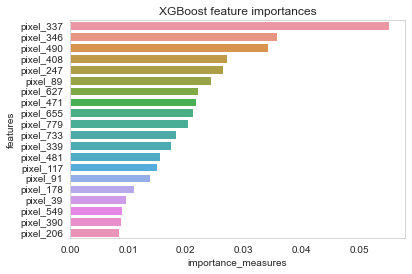

In [39]:
sns.barplot(x = "importance_measures", y ="features", data = df_feature_importance.iloc[:20, :])
plt.title("XGBoost feature importances")

### Let's try to understand the explanation of model prediction using SHAP

### SHAP Explanation

#### install the library using --> pip install shap


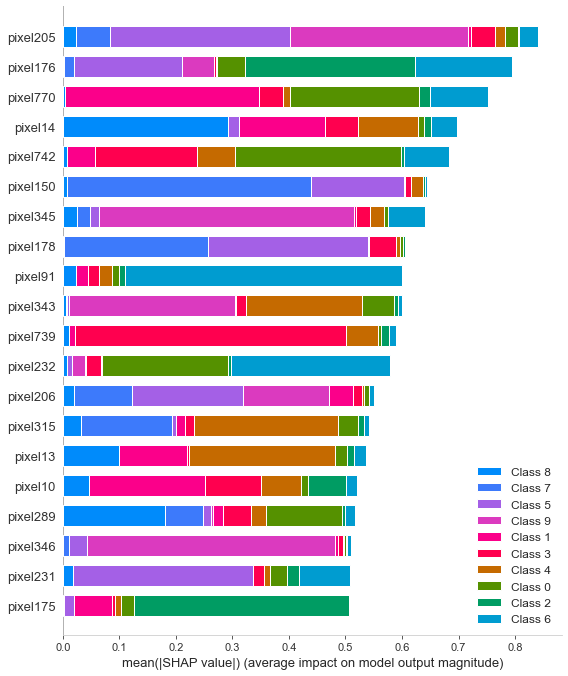

In [104]:
explainer = shap.TreeExplainer(xgb_model_fin)
shap_values = explainer.shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type='bar', feature_names=[f"pixel{i}" for i in range(X_train.shape[1])])

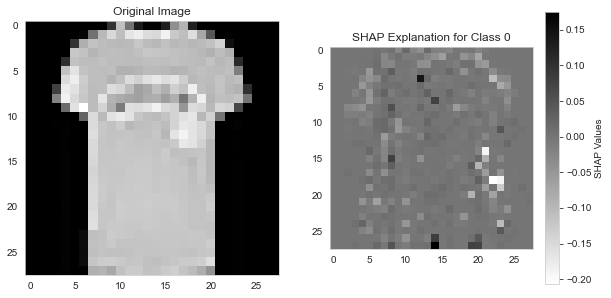

In [272]:
sample_index = 19
class_index = 0

shap_values_sample_class = shap_values[class_index][sample_index, :].reshape(28, 28)
original_image = X_test[sample_index].reshape(28, 28)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plotting the original image
axs[0].imshow(original_image, cmap='gray')
axs[0].set_title('Original Image')

# Plotting the SHAP values as an image plot for the specified class
im = axs[1].imshow(shap_values_sample_class, cmap='binary', vmin=np.min(shap_values_sample_class), vmax=np.max(shap_values_sample_class))
axs[1].set_title('SHAP Explanation for Class {}'.format(class_index))
cbar = plt.colorbar(im, ax=axs[1])
cbar.set_label('SHAP Values')
plt.show()

#Pastel2_r
#gist_rainbow
#ocean_r
#twilight_r
#icefire - bag - 30
#inferno

### LIME EXPLANATION

**install library using --> pip install lime**

In [298]:
from lime import lime_image
explainer = lime_image.LimeImageExplainer()

In [299]:
from skimage.color import gray2rgb, rgb2gray, label2rgb # since the code wants color images

def pred_fn(imgs):
    tot_probs = []
    for img in imgs:
        grayimg = rgb2gray(img)
        probs = xgb_model_fin.predict_proba(grayimg.reshape(1, -1))[0]
        tot_probs.append(probs)
    return tot_probs

pred_fn([X_test[1].reshape(28,28)])

The behavior of rgb2gray will change in scikit-image 0.19. Currently, rgb2gray allows 2D grayscale image to be passed as inputs and leaves them unmodified as outputs. Starting from version 0.19, 2D arrays will be treated as 1D images with 3 channels.


[array([2.18203408e-04, 1.40224365e-05, 9.96458113e-01, 3.93929586e-05,
        1.04788144e-03, 1.06735488e-05, 2.17327336e-03, 9.58927376e-06,
        8.77548518e-06, 2.01044950e-05], dtype=float32)]

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


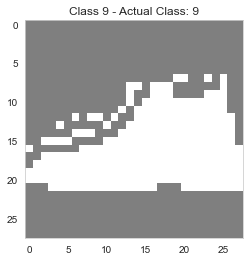

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


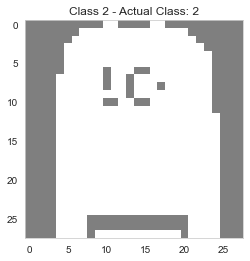

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


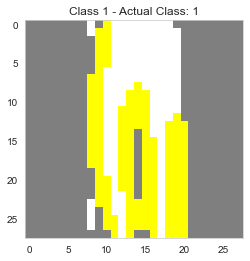

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


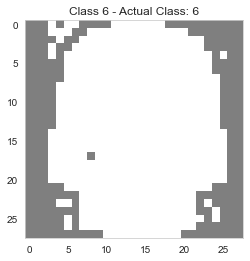

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


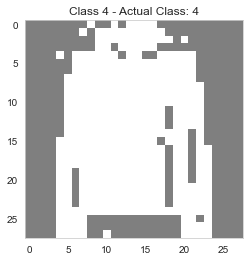

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


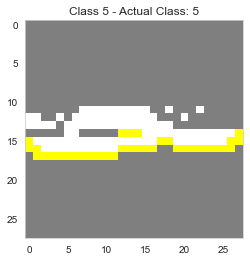

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


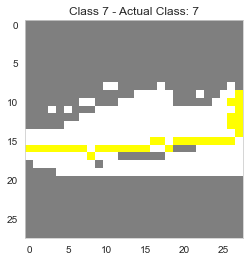

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


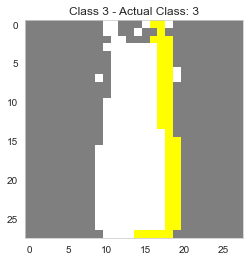

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


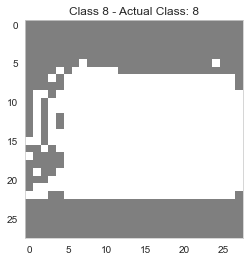

  0%|          | 0/1000 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


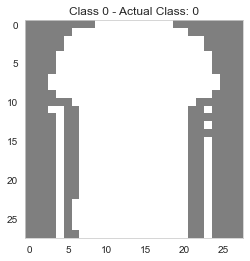

In [354]:
import random

# Initialize a set to keep track of selected classes
selected_classes = set()

for idx in range(len(X_test)):
    predicted_class = xgb_model_fin.predict(X_test[idx].reshape(1, -1))[0]
    if predicted_class not in selected_classes:

        explanation = explainer.explain_instance(gray2rgb(X_test[idx].reshape(28, 28)), 
                                                 classifier_fn=pred_fn,
                                                 top_labels=10)
        
        temp, mask = explanation.get_image_and_mask(predicted_class, num_features=784)

        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask),cmap='viridis')
        plt.title(f"Class {predicted_class} - Actual Class: {y_test[idx]}")
        plt.show()
        
        selected_classes.add(predicted_class)
        
    if len(selected_classes) == 10:
        break


To Do : Explore below
- joblib
- dask
- cupy
- cudf
- https://examples.dask.org/machine-learning.html